In [34]:
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from  datetime import datetime
import matplotlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
from tensorflow.python.client import timeline
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox

In [4]:
print('tf  version {v}'.format(v = tf.__version__))

tf  version 1.14.0


#### Preparing data

In [194]:
data = pd.read_csv('embedded_cat_and_num_df_subcases.csv')

In [195]:
data = data[(data.target < np.quantile(data.target, 0.9)) & 
           (data.target > np.quantile(data.target, 0.05))]

In [196]:
target = data['target'] / (24 * 60 * 60)

In [197]:
target = boxcox(target, lmbda= 0)

In [198]:
mean_target = np.mean(target)
std_target = np.std(target)

target = (target - mean_target) / std_target

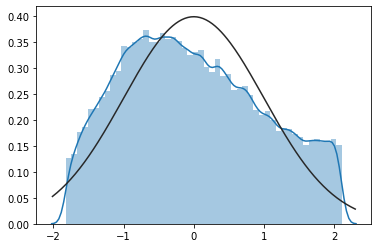

In [199]:
sns.distplot(target, fit = stats.norm)

In [200]:
X, y = data.drop(['target'], axis = 1).values, target

In [201]:
X.shape

(930650, 311)

In [202]:
y.shape

(930650,)

In [203]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)

In [205]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(744520, 311) (744520,)
(93065, 311) (93065,)
(93065, 311) (93065,)


#### MultiGPU

In [232]:
BATCH_SIZE = 2000
NUM_EPOCHS = 2
WDECAY = None
EDECAY = 0.999
gpus = tf.config.experimental.list_logical_devices(device_type = 'GPU')

In [207]:
def _locate_variable_on_cpu(name, shape, init, trainable = True):
    with tf.device('/cpu:0'):
        var = tf.get_variable(name = name,
                         shape = tf.TensorShape(shape),
                         initializer = init,
                         trainable = trainable)
    return var

In [208]:
def _locate_variable_on_cpu_wd(name, shape, init, wd, trainable = True):
    var = _locate_variable_on_cpu(name = name,
                               shape = shape,
                               init = init,
                               trainable = trainable)
    if wd is not None:
        var_wd = tf.multiply(tf.nn.l2_loss(var), wd)
        tf.add_to_collection('loss', var_wd)

    return var

In [209]:
def _generator_train():
    for x, y in zip(X_train, y_train):
        yield x, y

In [211]:
def _generator_val():
    for x, y in zip(X_val, y_val):
        yield x, y

In [222]:
def _generator_test():
    for x, y in zip(X_test, y_test):
        yield x, y

In [243]:
def _generate_batch(generator, batch_size):
    dataset = tf.data.Dataset.from_generator(generator,
                                           output_types = (tf.float32, tf.float32),
                                          output_shapes = (tf.TensorShape([311, ]), tf.TensorShape([])))
    dataset = dataset.prefetch(-1)
    dataset = dataset.repeat().batch(batch_size, drop_remainder = True)
    iterator = dataset.make_one_shot_iterator()
    batch = iterator.get_next()
    return batch

In [219]:
def get_input_train():
    return _generate_batch(_generator_train, len(gpus) * BATCH_SIZE)

In [220]:
def get_input_val():
    return _generate_batch(_generator_val, len(gpus) * BATCH_SIZE)

In [221]:
def get_input_test():
    return _generate_batch(_generator_test, len(gpus) * BATCH_SIZE)

In [237]:
def construct_graph_and_return_logits(x, reuse_variables):
    with tf.variable_scope('first_dense', reuse = reuse_variables):
        w1 = _locate_variable_on_cpu_wd('w', [311, 1024], tf.contrib.layers.xavier_initializer(), WDECAY)
        b1 = _locate_variable_on_cpu_wd('b', [1024, ], tf.zeros_initializer(), WDECAY)
    z1 = tf.nn.elu(tf.matmul(x, w1) + b1)

    with tf.variable_scope('second_dense', reuse = reuse_variables):
        w2 = _locate_variable_on_cpu_wd('w', [1024, 512], tf.contrib.layers.xavier_initializer(), WDECAY)
        b2 = _locate_variable_on_cpu_wd('b', [512, ], tf.zeros_initializer(), WDECAY)
    z2 = tf.nn.sigmoid(tf.matmul(z1, w2) + b2)

    with tf.variable_scope('third_dense', reuse = reuse_variables):
        w3 = _locate_variable_on_cpu_wd('w', [512, 256], tf.contrib.layers.xavier_initializer(), WDECAY)
        b3 = _locate_variable_on_cpu_wd('b', [256, ], tf.zeros_initializer(), WDECAY)
    z3 = tf.nn.elu(tf.matmul(z2, w3) + b3)

    with tf.variable_scope('fourth_dense', reuse = reuse_variables):
        w4 = _locate_variable_on_cpu_wd('w', [256, 128], tf.contrib.layers.xavier_initializer(), WDECAY)
        b4 = _locate_variable_on_cpu_wd('b', [128, ], tf.zeros_initializer(), WDECAY)
    z4 = tf.nn.sigmoid(tf.matmul(z3, w4) + b4)

    with tf.variable_scope('fivth_dense', reuse = reuse_variables):
        w5 = _locate_variable_on_cpu_wd('w', [128, 64], tf.contrib.layers.xavier_initializer(), WDECAY)
        b5 = _locate_variable_on_cpu_wd('b', [64, ], tf.zeros_initializer(), WDECAY)
    z5 = tf.nn.elu(tf.matmul(z4, w5) + b5)

    with tf.variable_scope('sixth_dense', reuse = reuse_variables):
        w6 = _locate_variable_on_cpu_wd('w', [64, 32], tf.contrib.layers.xavier_initializer(), WDECAY)
        b6 = _locate_variable_on_cpu_wd('b', [32, ], tf.zeros_initializer(), WDECAY)
    z6 = tf.nn.sigmoid(tf.matmul(z5, w6) + b6)

    with tf.variable_scope('final_dense', reuse = reuse_variables):
        w7 = _locate_variable_on_cpu_wd('w', [32, 1], tf.contrib.layers.xavier_initializer(), WDECAY)
        b7 = _locate_variable_on_cpu_wd('b', [1, ], tf.zeros_initializer(), WDECAY)
    out = tf.matmul(z6, w7) + b7

    logits = tf.squeeze(out)

    return logits

In [223]:
def compute_loss_for_tower(logits, true, scope):
    with tf.name_scope('main_loss'):
        main_loss = tf.reduce_mean(tf.square(logits - true))

    tf.add_to_collection('loss', main_loss)

    tf.add_to_collection('main_losses', main_loss)

    loss_for_tower = tf.reduce_sum(tf.get_collection('loss', scope = scope))

    loss_for_test = tf.reduce_mean(tf.abs(logits - true), name = 'test_loss')
    tf.add_to_collection('test_losses',
                        loss_for_test)
    
    return loss_for_tower

In [217]:
def average_gradients():
    grads_and_vars = tf.get_collection('grads_and_vars')
    averaged_grads_and_vars = []
    
    for elem in zip(*grads_and_vars):
        average_gradient = []
        shape = tf.shape(elem[0][0])
        for grad, var in elem:
            grad = tf.reshape(grad, (-1, ))
            average_gradient.append(grad)
        average_gradient = tf.reduce_mean(average_gradient, axis = 0)
        average_gradient = tf.reshape(average_gradient, shape, name = 'gradient_at_{v}'.format(v = var.op.name))
        averaged_grads_and_vars.append((average_gradient, var))
        
    return averaged_grads_and_vars

In [225]:
def construct_graph(graph):
    reuse_variables = False

    summaries = []

    with graph.as_default():
        with tf.device('/cpu:0'):
            with tf.name_scope('things_for_set_up'):
                step = _locate_variable_on_cpu(name = 'global_step',
                                              shape = [],
                                              init = tf.constant_initializer(0),
                                              trainable = False)
                flag_for_queue = _locate_variable_on_cpu(name = 'flag_queues',
                                                        shape = [],
                                                        init = tf.constant_initializer(0),
                                                        trainable = False)
                flag_update_op = tf.assign(flag_for_queue, flag_for_queue + 1, name = 'update_flag')

                optimizer = tf.train.AdamOptimizer(3e-04)

                ema = tf.train.ExponentialMovingAverage(decay = EDECAY)

                with tf.name_scope('inputs'):
                    flag_indicator = tf.cast(tf.math.floormod(flag_for_queue, tf.constant(2.)), tf.bool)
                    
                    @tf.function
                    def train_val_input():
                        out = tf.cond(flag_indicator,
                                    get_input_val,
                                    get_input_train)
                        return out
                    
                    assign_for_test_op = tf.assign(flag_for_queue, tf.constant(-1.), name = 'assign_for_test_op')
                    
                    flag_negative_operation = tf.math.greater_equal(flag_for_queue, tf.constant(0.))
                    
                    x_input, y_input = tf.cond(flag_negative_operation,
                                               train_val_input,
                                               get_input_test)
                    
                    queue = tf.contrib.slim.prefetch_queue.prefetch_queue([x_input, y_input],
                                                                         capacity = 2)
                    x, y = queue.dequeue()

            for index, gpu in enumerate(gpus):
                with tf.name_scope('tower{t}'.format(t = index)):
                    with tf.device(gpu.name):
                        x_tower_input = x[index * BATCH_SIZE: (index + 1) * BATCH_SIZE]
                        y_tower_input = y[index * BATCH_SIZE: (index + 1) * BATCH_SIZE]

                        logits  = construct_graph_and_return_logits(x_tower_input, 
                                                                   reuse_variables)

                        tf.add_to_collection('logits', logits)

                        loss = compute_loss_for_tower(logits, y_tower_input, 'tower{t}'.format(t = index))

                        tower_loss_summary = tf.summary.scalar('loss_for_{t}_tower'.format(t = index), loss)
                        summaries.append(tower_loss_summary)

                        grads_vars = optimizer.compute_gradients(loss)

                        tf.add_to_collection('grads_and_vars', grads_vars)

                        reuse_variables = True

            total_loss = tf.reduce_mean(tf.get_collection('main_losses'))

            loss_summary = tf.summary.scalar('loss_total', total_loss)
            summaries.append(loss_summary)

            test_loss_averaged = tf.reduce_mean(tf.get_collection('test_losses'), name = 'test_loss')
            
            logits_agregated = tf.concat(tf.get_collection('logits'),
                                        axis = 0,
                                        name = 'logits_aggregation')



            grads_and_vars = average_gradients()

            with tf.name_scope('summaries_gradients'):
                for grad, var in grads_and_vars:
                    if grad is not None:
                        summaries.append(tf.summary.histogram('grad_for_var_{v}'.format(v = var.op.name),
                                                         grad))

            with tf.name_scope('summaries_variables'):
                for var in tf.trainable_variables():
                    summaries.append(tf.summary.histogram('val_for_{v}'.format(v = var.op.name),
                                                   var))

            with tf.name_scope('ema_operation'):
                ema_op = ema.apply(tf.trainable_variables())

            with tf.name_scope('summaries_ema'):
                for var in tf.trainable_variables():
                    summaries.append(tf.summary.histogram('ema_for_{v}'.format(v = var.op.name),
                                                       ema.average(var)))

            op_grads = optimizer.apply_gradients(grads_and_vars, global_step = step, name = 'update_grad_op')

            merge_op = tf.summary.merge(summaries, name = 'merge_training')
            merge_op_val = tf.summary.merge([loss_summary], name = 'val_merging')

            train_op = tf.group(op_grads, ema_op)

            with tf.name_scope('saving_and_restoring'):
                saver = tf.train.Saver()
                imported_graph = tf.train.export_meta_graph()

    return step, train_op, merge_op, merge_op_val, flag_update_op, saver

In [245]:
graph = tf.Graph()

step, train_op, merge_op, merge_op_val, flag_update_op, saver = construct_graph(graph)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


In [246]:
! rm -r './regression_model_embedded_cat_feats'

In [247]:
### to ensure we use TB in appropriate way: we accumulate data of different
### training runs in different subdirectories of main log directory,
### so when you start TB it shows all the runs in comparing to each other

### note also, that if you use tb 1.14, then you should upgrade it via
### conda, so the error: Normalising Names Failed (Graph) wont appear
### and notice, if you work in multiple environment you should start 
### tb from the environment, where upgraded tb is placed
now = datetime.now()
logdir = os.path.join(os.getcwd(), 'regression_model_embedded_cat_feats')
current_time = now.strftime("%Y%m%d-%H%M%S")
current_logdir_train = os.path.join(logdir, current_time, 'train')
current_logdir_test = os.path.join(logdir, current_time, 'test')

PATH_TO_SAVE = './regression_model_cat_feats_embedded_saved/ckpt'

In [248]:
configure = tf.ConfigProto(allow_soft_placement = True, log_device_placement = False)

In [249]:
current_step = 0

num_steps = NUM_EPOCHS * (len(X_train) // ((len(gpus) * BATCH_SIZE)))

In [250]:
with tf.Session(graph = graph, config = configure) as sess:
    writer_train = tf.summary.FileWriter(current_logdir_train, graph = graph)
    writer_test = tf.summary.FileWriter(current_logdir_test, graph = graph)
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(sess = sess, coord = coord)
    
    run_options = tf.RunOptions(trace_level = tf.RunOptions.FULL_TRACE)
    
    for _ in tqdm_notebook(range(num_steps)):
        if current_step % 100 == 0:
            run_metadata = tf.RunMetadata()
            current_step, _, summary_train = sess.run([step, train_op, merge_op],
                                                options = run_options,
                                                run_metadata = run_metadata)
            
            if current_step == 1:
                fetched_timeline = timeline.Timeline(run_metadata.step_stats)
                chrome_trace = fetched_timeline.generate_chrome_trace_format()
                with open('./timeline_first_step.json', 'w') as f:
                    f.write(chrome_trace)
              
                  
            _ = sess.run(flag_update_op)
            summary_val, _ = sess.run([merge_op_val, flag_update_op])
            
            writer_train.add_summary(summary_train, current_step)
            writer_train.add_run_metadata(run_metadata, 'step_{s}'.format(s = current_step))
            
            writer_test.add_summary(summary_val, current_step)
        else:
            current_step, _, summary_train = sess.run([step, train_op, merge_op])
            writer_train.add_summary(summary_train, current_step)
     
    coord.request_stop()
    
    saver.save(sess = sess,
              save_path = PATH_TO_SAVE)
    
    fetched_timeline = timeline.Timeline(run_metadata.step_stats)
    chrome_trace = fetched_timeline.generate_chrome_trace_format()
    with open('./timeline_finish_step.json', 'w') as f:
        f.write(chrome_trace)
        

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'



Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


### Import model and reset smth

In [0]:
tf.reset_default_graph()

In [0]:
graph_eval = tf.Graph()

with tf.Session(config = configure, graph = graph_eval) as sess:
  saver_restore = tf.train.import_meta_graph(imported_graph)
  saver_restore.restore(sess = sess,
                        save_path = PATH_TO_SAVE)
  
  coord = tf.train.Coordinator()
  tf.train.start_queue_runners(sess = sess,
                              coord = coord)
  
  op_for_logits = graph_eval.get_tensor_by_name('logits_eval_op/logits_eval_op:0')
  
  for _ in tqdm(range(num_steps_eval)):
    prediction = sess.run(op_for_logits)
    total_prediction.append(prediction)
    
  coord.request_stop()

INFO:tensorflow:Restoring parameters from ./regression_model_saved/ckpt


100%|██████████| 350/350 [00:33<00:00, 10.48it/s]


### Depict loss surface

#### Get initial weights

In [0]:
########## we need this to ensure we do not have default graph
########## this could happen when importing meta graph
########## when you import meta graph through import_meta_graph, meta graph automatically becomes default graph
tf.reset_default_graph()

In [0]:
variables = {}

with tf.Session(config = configure) as sess:
  saver_restore = tf.train.import_meta_graph(imported_graph)

  saver_restore.restore(sess = sess,
                        save_path = PATH_TO_SAVE)

  for var in tf.trainable_variables():
    variables[var.op.name] = var.eval()

#### Prepare grids and vectors

In [0]:
delta_vectors_raw = [np.random.normal(size = elem.shape) for elem in variables.values()]
nu_vectors_raw = [np.random.normal(size = elem.shape) for elem in variables.values()]

In [0]:
def normalize_filters(filters):
  normalized_vectors = []
  for variable, filter in zip(variables.values(), filters):
    filter_norms = np.linalg.norm(filter, axis = 0)
    filter_normalized = filter / filter_norms
    var_norms = np.linalg.norm(variable, axis = 0)
    scaled_filter = filter_normalized * var_norms
    normalized_vectors.append(scaled_filter)
    
  return normalized_vectors

In [0]:
delta_vectors, nu_vectors = normalize_filters(delta_vectors_raw), normalize_filters(nu_vectors_raw)

In [0]:
xs, ys = np.linspace(-1, 1, 30), np.linspace(-1, 1, 30)
X, Y = np.meshgrid(xs, ys)
x, y = np.ravel(X), np.ravel(Y)

zs = []

#### Do main job

In [0]:
X_train = X_train[:len(gpus) * config['batch_size']]
y_train = y_train[:len(gpus) * config['batch_size']]
lens_train = lens_train[:len(gpus) * config['batch_size']]

In [0]:
##### here we got narrow place: 
##### when you run tf.assign with python object, you create new operation in your graph
##### hence, graph takes more memory, because it has more operations, hence
##### it slows down computation and every new step is executed slower

graph_depict = tf.Graph()

In [0]:
step, train_op, summary_op, summary_op_loss, flag_update_op, saver, imported_graph, loss = construct_graph(graph_depict)

In [0]:
with graph_depict.as_default():
  placeholders = [tf.placeholder(dtype = tf.float32, shape = elem.shape, name = 'p_r_' + key) for key, elem in variables.items()]
  
  assign_ops = [tf.assign(var, value, name = 'assign_' + var.op.name) for var, value in zip(tf.trainable_variables(), placeholders)]
    

In [0]:
with tf.Session(config = configure, graph = graph_depict) as sess:
  sess.run(tf.global_variables_initializer())
  coord = tf.train.Coordinator()
  tf.train.start_queue_runners(sess = sess,
                              coord = coord)
  ########### initialize variables with asterisk values
  sess.run(assign_ops, feed_dict = {placeholder: value for placeholder, value in zip(placeholders, variables.values())})
  initial_loss = sess.run(loss)

  for alpha, beta in tqdm(zip(x, y), total = len(x)):
      current_vector_delta = [alpha * elem for elem in delta_vectors]
      current_vector_nu = [beta * elem for elem in nu_vectors]
      current_variables = [var + elem_delta + elem_nu for var, elem_delta, elem_nu in zip(variables.values(), current_vector_delta, current_vector_nu)]

      sess.run(assign_ops, feed_dict = {placeholder: value for placeholder, value in zip(placeholders, current_variables)})
      current_loss = sess.run(loss)
      zs.append(current_loss)

  coord.request_stop()  

#### Depict loss surface

In [0]:
fig = plt.figure()

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(0, 0, initial_loss,  c = 'r', s = 300, depthshade = False)

Z = np.reshape(zs, newshape = X.shape)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
fig.colorbar(surf)

ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Loss')

ax.view_init(50, 10)

plt.show()

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
ax.plot(0, 0, 'bo', c = 'r')

### Test

In [251]:
losses = []
logits_predictions = []

In [253]:
num_steps_test = len(X_test) // (BATCH_SIZE * len(gpus))

In [254]:
graph_test = tf.Graph()

with graph_test.as_default():
    saver_restore = tf.train.import_meta_graph(PATH_TO_SAVE + '.meta')
    assign_op = graph_test.get_operation_by_name('things_for_set_up/inputs/assign_for_test_op')
    test_loss = graph_test.get_tensor_by_name('test_loss:0')
    predictions = graph_test.get_tensor_by_name('logits_aggregation:0')

    
    with tf.Session(config = configure) as sess:
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        tf.train.start_queue_runners(sess = sess,
                                    coord = coord)        
        
        saver_restore.restore(sess,
                             PATH_TO_SAVE)
                
        sess.run(assign_op)
        
        for _ in tqdm_notebook(range(num_steps_test)):
            loss, pred = sess.run([test_loss, predictions])
            losses.append(loss)
            logits_predictions.append(pred)
        
        coord.request_stop()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./regression_model_cat_feats_embedded_saved/ckpt


In [ ]:
print('number of days {d}'.format(d = np.mean(losses) * (y_scaler.data_max_ - y_scaler.data_min_)[0] / 86400))

In [ ]:
logits_to_plot = list(chain(*logits_predictions))

In [ ]:
sns.distplot(logits_to_plot, label = 'predict')
sns.distplot(y_test, label = 'true')
plt.legend()